# Experimento 3 : Planificación del entrenamiento.


## Librerías usadas.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import math 
from glob import glob
from matplotlib import pyplot as plt
import os
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

In [1]:
import tensorflow as tf
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

## Definición de rutas

In [3]:
#Rutas de los datos.
 
data_dir = os.path.dirname(os.path.realpath("../TFG/Datos/HAM10000_metadata.csv"))



csv_path = os.path.realpath(data_dir + "/HAM10000_metadata.csv")

#Variables globales

altura = 128
longitud = 128
clases = 7


print(data_dir)

print(csv_path)



/home/antgarnie/Escritorio/TFG/Datos
/home/antgarnie/Escritorio/TFG/Datos/HAM10000_metadata.csv


## Creación del marco de datos.

In [4]:
#Inicializando el dataFrame

dataFrame=pd.read_csv(csv_path)

#Mezclando carpetas.

all_image_path = glob(os.path.join(data_dir, '*', '*'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}

# Inicializando diccionario de categorías

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

#Añadiendo columnas al dataFrame para que sea más legible.

dataFrame['path'] = dataFrame['image_id'].map(imageid_path_dict.get)
dataFrame['cell_type'] = dataFrame['dx'].map(lesion_type_dict.get) 
dataFrame['cell_type_idx'] = pd.Categorical(dataFrame['cell_type']).codes
dataFrame.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/home/antgarnie/Escritorio/TFG/Datos/HAM10000_...,Benign keratosis,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/home/antgarnie/Escritorio/TFG/Datos/HAM10000_...,Benign keratosis,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/home/antgarnie/Escritorio/TFG/Datos/HAM10000_...,Benign keratosis,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/home/antgarnie/Escritorio/TFG/Datos/HAM10000_...,Benign keratosis,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/home/antgarnie/Escritorio/TFG/Datos/HAM10000_...,Benign keratosis,2


## Preparación de la red



In [5]:
def full_build_cnn_soco(withBatchNormalization = False, withDropout=False):
    
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Conv2D(32, (3,3),(1,1),input_shape=(altura,longitud,3)))
    model.add(tf.keras.layers.PReLU())
    if(withBatchNormalization):
        model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2D(32, (3,3),(1,1)))
    model.add(tf.keras.layers.PReLU())
    if(withBatchNormalization):
        model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.MaxPooling2D((2,2)))

 
    model.add(tf.keras.layers.Conv2D(64, (3,3)))
    model.add(tf.keras.layers.PReLU())
    if(withBatchNormalization):
        model.add(tf.keras.layers.BatchNormalization())
        
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    
    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(128))
    model.add(tf.keras.layers.PReLU())
    if(withDropout):
        model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(clases,activation='softmax'))

    return model

## Se procede a crear un método que permita balancear la carga de imágenes

In [6]:
def balanced_dataset(df):
    df_balanced = pd.DataFrame()
    #df = pd.DataFrame()
    
    for cat in df['cell_type_idx'].unique():
        temp = resample(df[df['cell_type_idx'] == cat], 
                        replace=True,     # sample with replacement
                        n_samples=2500,   # to match majority class
                        random_state=123) # reproducible results

        # Combine majority class with upsampled minority class
        df_balanced = pd.concat([df_balanced, temp])
 
    df_balanced['cell_type'].value_counts()

    return df_balanced

def load_img_data(size, df, balanced=False):
    """
        ..
        first we should normalize the image from 0-255 to 0-1
    """
    
    img_h, img_w = size, size
    imgs = []
    
    if balanced:
        df = balanced_dataset(df)
    
    image_paths = list(df['path'])

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        img = img.astype(np.float32) / 255.
        #img = np.asarray(Image.open(image_paths[i]).resize((size,size)))
        imgs.append(img)

    imgs = np.stack(imgs, axis=0)
    print(imgs.shape)

    #imgs = imgs.astype(np.float32) / 255.
    
    return imgs, df['cell_type_idx'].values

## Cargamos los datos y creamos los casos a experimentar.

In [7]:
def load_general_data():
    
    imgs, target = load_img_data(altura, dataFrame, balanced=True)
    
    x_train, x_transferLearning, y_train, y_transferLearning = train_test_split(imgs, target, test_size=0.60)
       
    source_data = [ x_transferLearning , y_transferLearning ]
    target_data = [ x_train , y_train ]
    
    x_train,x_test,y_train,y_test = train_test_split(target_data[0], target_data[1], test_size=0.70)
    
    train_data = [x_train,y_train]
    test_data = [x_test,y_test]
    
    return source_data,train_data,test_data


def get_data_for_ex(source_data,train_data,test_data):
    
    x_train = source_data[0]
    y_train = source_data[1]
    
    x_retrain = train_data[0]
    y_retrain = train_data[1]
    
    percent = math.floor(len(test_data[0])/100*30)
       
    x_validation = test_data[0][0:percent]
    y_validation = test_data[1][0:percent]
    
    
    x_test = test_data[0][percent:-1]
    y_test = test_data[1][percent:-1]
    
    return x_train,x_retrain,x_test,x_validation,y_train,y_retrain,y_test,y_validation


###############################################################################################################
# Definimos 7 experimentos cada uno con un optimizador distingo y definimos el número de iteraciones          #
###############################################################################################################

ITERATIONS_PER_EXP = 10
BATCH_SIZE = 16
EPOCHS = 15
LEARNING_RATE=0.0001

In [8]:
source_data,train_data,test_data = load_general_data()
x_train,x_retrain,x_test,x_validation,y_train,y_retrain,y_test,y_validation = get_data_for_ex(source_data,train_data,test_data)

100%|██████████| 17500/17500 [01:52<00:00, 155.89it/s]


(17500, 128, 128, 3)


In [9]:
def scheduler(epoch, lr):
    return 0.001


In [ ]:
 if epoch < 5:
        print(lr)
        return float(lr)
    elif 5 >= epoch < 10:
        print(lr)
        return float(lr)*0.80
    elif 5 >= epoch < 15:
        print(lr)
        return float(lr)*0.70
    else:
        print(lr)
        return float(lr)*0.50

In [15]:
#Experimento 1. Red con soco.
res11,res12,evaluations,evaluations1 = run_experiment(0,20)

ResourceExhaustedError: OOM when allocating tensor with shape[3,3,32,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

(128, 128, 3)


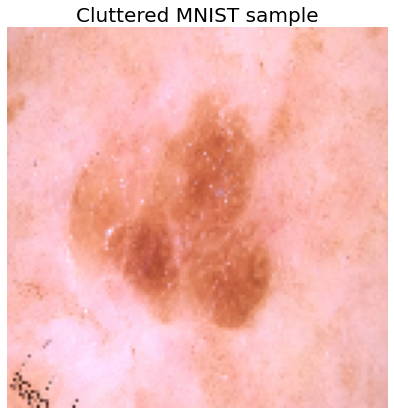

In [10]:



def plot_sample(sample):
    #mnist_sample = np.squeeze(mnist_sample)
    image = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
    sample = np.array(image)
    print(sample.shape)
    plt.figure(figsize=(7, 7))
    plt.imshow(sample)
    plt.title('Cluttered MNIST sample', fontsize=20)
    plt.axis('off')
    plt.show()
    
plot_sample(x_train[1])

In [20]:


#Experimento 2. Red con soco con BN y Dropout.
res21,res22,evaluations,evaluations2 = run_experiment(1,15)

#Experimento 3. Red con soco con BN y sin Dropout.
res31,res32,evaluations,evaluations3 = run_experiment(2,15)


Epoch 1/15
875/875 [==============================] - 49s 56ms/step - loss: 1.4938 - accuracy: 0.3994 - val_loss: 1.1787 - val_accuracy: 0.5571
Epoch 2/15
875/875 [==============================] - 40s 46ms/step - loss: 1.0898 - accuracy: 0.5838 - val_loss: 0.8544 - val_accuracy: 0.6755
Epoch 3/15
875/875 [==============================] - 40s 46ms/step - loss: 0.7781 - accuracy: 0.7087 - val_loss: 0.6521 - val_accuracy: 0.7524
Epoch 4/15
875/875 [==============================] - 41s 47ms/step - loss: 0.5563 - accuracy: 0.7950 - val_loss: 0.4491 - val_accuracy: 0.8449
Epoch 5/15
875/875 [==============================] - 41s 47ms/step - loss: 0.4081 - accuracy: 0.8503 - val_loss: 0.4656 - val_accuracy: 0.8449
Epoch 6/15
875/875 [==============================] - 41s 47ms/step - loss: 0.3107 - accuracy: 0.8871 - val_loss: 0.4605 - val_accuracy: 0.8497
Epoch 7/15
875/875 [==============================] - 41s 47ms/step - loss: 0.2634 - accuracy: 0.9026 - val_loss: 0.3896 - val_accuracy:

108/108 [==============================] - 3s 27ms/step - loss: 0.3809 - accuracy: 0.9312
########################################################
Iteración 5 de 10
########################################################
Epoch 1/15
875/875 [==============================] - 39s 45ms/step - loss: 1.5334 - accuracy: 0.3778 - val_loss: 1.2539 - val_accuracy: 0.5184
Epoch 2/15
875/875 [==============================] - 39s 45ms/step - loss: 1.1699 - accuracy: 0.5508 - val_loss: 0.9694 - val_accuracy: 0.6279
Epoch 3/15
875/875 [==============================] - 39s 45ms/step - loss: 0.8962 - accuracy: 0.6625 - val_loss: 0.7533 - val_accuracy: 0.7170
Epoch 4/15
875/875 [==============================] - 39s 44ms/step - loss: 0.6757 - accuracy: 0.7497 - val_loss: 0.5485 - val_accuracy: 0.8041
Epoch 5/15
875/875 [==============================] - 39s 45ms/step - loss: 0.5078 - accuracy: 0.8183 - val_loss: 0.5074 - val_accuracy: 0.8163
Epoch 6/15
875/875 [==============================] - 40s 

Epoch 7/15
875/875 [==============================] - 40s 45ms/step - loss: 0.2748 - accuracy: 0.9012 - val_loss: 0.3385 - val_accuracy: 0.8939
Epoch 8/15
875/875 [==============================] - 39s 45ms/step - loss: 0.2098 - accuracy: 0.9233 - val_loss: 0.2878 - val_accuracy: 0.9170
Epoch 9/15
875/875 [==============================] - 39s 45ms/step - loss: 0.1853 - accuracy: 0.9309 - val_loss: 0.3177 - val_accuracy: 0.9075
Epoch 10/15
875/875 [==============================] - 39s 45ms/step - loss: 0.1516 - accuracy: 0.9460 - val_loss: 0.2983 - val_accuracy: 0.9265
Epoch 11/15
875/875 [==============================] - 39s 45ms/step - loss: 0.1375 - accuracy: 0.9501 - val_loss: 0.3293 - val_accuracy: 0.9143
Epoch 12/15
875/875 [==============================] - 39s 45ms/step - loss: 0.1259 - accuracy: 0.9539 - val_loss: 0.3587 - val_accuracy: 0.9163
Epoch 13/15
875/875 [==============================] - 39s 45ms/step - loss: 0.1197 - accuracy: 0.9572 - val_loss: 0.3793 - val_accur

Epoch 4/15
875/875 [==============================] - 12s 14ms/step - loss: 0.0558 - accuracy: 0.9814 - val_loss: 0.3627 - val_accuracy: 0.9231
Epoch 5/15
875/875 [==============================] - 12s 14ms/step - loss: 0.0599 - accuracy: 0.9791 - val_loss: 0.3749 - val_accuracy: 0.9224
Epoch 6/15
875/875 [==============================] - 12s 14ms/step - loss: 0.0584 - accuracy: 0.9798 - val_loss: 0.3655 - val_accuracy: 0.9259
Epoch 7/15
108/108 [==============================] - 3s 27ms/step - loss: 0.3612 - accuracy: 0.9367
########################################################
Iteración 10 de 10
########################################################
Epoch 1/15
875/875 [==============================] - 49s 56ms/step - loss: 1.6933 - accuracy: 0.4165 - val_loss: 1.0868 - val_accuracy: 0.5823
Epoch 2/15
875/875 [==============================] - 49s 56ms/step - loss: 1.1094 - accuracy: 0.5802 - val_loss: 0.8266 - val_accuracy: 0.6844
Epoch 3/15
875/875 [==========================

Epoch 6/15
875/875 [==============================] - 49s 56ms/step - loss: 0.3780 - accuracy: 0.8618 - val_loss: 0.3243 - val_accuracy: 0.8789
Epoch 7/15
875/875 [==============================] - 49s 56ms/step - loss: 0.3231 - accuracy: 0.8820 - val_loss: 0.4087 - val_accuracy: 0.8463
Epoch 8/15
875/875 [==============================] - 49s 56ms/step - loss: 0.2444 - accuracy: 0.9113 - val_loss: 0.3505 - val_accuracy: 0.8959
Epoch 9/15
875/875 [==============================] - 49s 56ms/step - loss: 0.2010 - accuracy: 0.9298 - val_loss: 0.3174 - val_accuracy: 0.8932
Epoch 10/15
875/875 [==============================] - 49s 56ms/step - loss: 0.1829 - accuracy: 0.9332 - val_loss: 0.6092 - val_accuracy: 0.8048
Epoch 11/15
875/875 [==============================] - 49s 56ms/step - loss: 0.1617 - accuracy: 0.9401 - val_loss: 0.2580 - val_accuracy: 0.9170
Epoch 12/15
875/875 [==============================] - 49s 56ms/step - loss: 0.1244 - accuracy: 0.9545 - val_loss: 0.3480 - val_accura

875/875 [==============================] - 49s 56ms/step - loss: 1.2022 - accuracy: 0.5516 - val_loss: 0.9992 - val_accuracy: 0.5993
Epoch 3/15
875/875 [==============================] - 49s 56ms/step - loss: 0.8698 - accuracy: 0.6728 - val_loss: 0.9498 - val_accuracy: 0.6565
Epoch 4/15
875/875 [==============================] - 49s 56ms/step - loss: 0.6500 - accuracy: 0.7544 - val_loss: 0.7583 - val_accuracy: 0.7320
Epoch 5/15
875/875 [==============================] - 49s 56ms/step - loss: 0.5286 - accuracy: 0.8051 - val_loss: 0.7575 - val_accuracy: 0.7442
Epoch 6/15
875/875 [==============================] - 50s 57ms/step - loss: 0.4262 - accuracy: 0.8435 - val_loss: 0.9223 - val_accuracy: 0.7048
Epoch 7/15
875/875 [==============================] - 49s 56ms/step - loss: 0.3435 - accuracy: 0.8723 - val_loss: 1.3622 - val_accuracy: 0.6367
Epoch 8/15
875/875 [==============================] - 49s 56ms/step - loss: 0.3016 - accuracy: 0.8886 - val_loss: 0.4764 - val_accuracy: 0.8381
Epo

875/875 [==============================] - 40s 45ms/step - loss: 0.0860 - accuracy: 0.9718 - val_loss: 0.2913 - val_accuracy: 0.9259
Epoch 8/15
875/875 [==============================] - 39s 45ms/step - loss: 0.0786 - accuracy: 0.9741 - val_loss: 0.3832 - val_accuracy: 0.9048
Epoch 9/15
875/875 [==============================] - 40s 45ms/step - loss: 0.0455 - accuracy: 0.9835 - val_loss: 0.2956 - val_accuracy: 0.9374
Epoch 10/15
875/875 [==============================] - 39s 45ms/step - loss: 0.0363 - accuracy: 0.9877 - val_loss: 0.4313 - val_accuracy: 0.9000
Epoch 11/15
875/875 [==============================] - 40s 45ms/step - loss: 0.0464 - accuracy: 0.9857 - val_loss: 0.4316 - val_accuracy: 0.9122
Epoch 12/15
875/875 [==============================] - 39s 45ms/step - loss: 0.0251 - accuracy: 0.9930 - val_loss: 0.4197 - val_accuracy: 0.9252
3429
108/108 [==============================] - 3s 27ms/step - loss: 0.4485 - accuracy: 0.9221
Epoch 1/15
875/875 [=============================

Epoch 1/15
875/875 [==============================] - 39s 45ms/step - loss: 1.4446 - accuracy: 0.4220 - val_loss: 1.1901 - val_accuracy: 0.5415
Epoch 2/15
875/875 [==============================] - 39s 45ms/step - loss: 0.8536 - accuracy: 0.6828 - val_loss: 0.7346 - val_accuracy: 0.7272
Epoch 3/15
875/875 [==============================] - 39s 45ms/step - loss: 0.5064 - accuracy: 0.8139 - val_loss: 0.5369 - val_accuracy: 0.8034
Epoch 4/15
875/875 [==============================] - 39s 45ms/step - loss: 0.3198 - accuracy: 0.8846 - val_loss: 0.4495 - val_accuracy: 0.8565
Epoch 5/15
875/875 [==============================] - 40s 46ms/step - loss: 0.2069 - accuracy: 0.9285 - val_loss: 0.4318 - val_accuracy: 0.8782
Epoch 6/15
875/875 [==============================] - 39s 45ms/step - loss: 0.1225 - accuracy: 0.9569 - val_loss: 0.3692 - val_accuracy: 0.9061
Epoch 7/15
875/875 [==============================] - 39s 45ms/step - loss: 0.0793 - accuracy: 0.9713 - val_loss: 0.3516 - val_accuracy:

In [11]:
def run_train(nn_base_arch,epochs,checkpoint,dense = False):
    nn = select_network(nn_base_arch)
    
    if dense == True :
        model = build_dense(nn)
    else:
        model = build(nn)
        
    cpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint, monitor="val_loss", mode="min", save_best_only=True, verbose=0)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy','mse'])
    
    history = model.fit(x_train, y_train,epochs=EPOCHS,callbacks=[cpoint],batch_size = BATCH_SIZE,verbose=0)
      
    evaluation = model.evaluate(x_test, y_test)
        
    return history,evaluation

def run_train_w_model(model,epochs,output_layer):
        
    opt = tf.keras.optimizers.Adam(learning_rate=0.001,amsgrad=True)
    
    cbs = tf.keras.callbacks.LearningRateScheduler(scheduler)
        
    earlyStopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                patience = 3,
                                                mode = 'min')    
    
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    history = model.fit(x_train, y_train,validation_data=(x_validation, y_validation),epochs=epochs,
                        callbacks=[earlyStopping,cbs],batch_size = BATCH_SIZE)
    
    print(len(x_test))
    
    evaluation = model.evaluate(x_test, y_test)
        
    return history,evaluation,model
    
def re_train(model,checkpoint,epochs):
    
    cbs = tf.keras.callbacks.LearningRateScheduler(scheduler)
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.001,amsgrad=True)

    earlyStopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                patience = 3,
                                                mode = 'min')    
    
    cpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint,
                                                monitor="val_loss",
                                                mode="min",
                                                save_best_only=True,
                                                verbose=0)
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    history = model.fit(x_train, y_train,validation_data=(x_validation, y_validation),epochs=epochs,callbacks=[earlyStopping,cbs,cpoint],batch_size = BATCH_SIZE)
    evaluation = model.evaluate(x_test, y_test)
    return history,evaluation,model

In [12]:
from tensorflow.keras.callbacks import LearningRateScheduler
def run_experiment(index_model,epoch,iterations = ITERATIONS_PER_EXP):
    result = []
    result_post_tf = []
    evaluations = []
    evaluations_post_tf = []
    dense = False
    
    for i in range(iterations):
        checkpoint ="../TFG/Modelos/balanced_model_functionalv2.h5"
        
        if index_model == 0:
            model = full_build_cnn_soco(withBatchNormalization = False, withDropout=True)
        if index_model == 1:
            model = full_build_cnn_soco(withBatchNormalization = True, withDropout=True)
        if index_model == 2:
            model = full_build_cnn_soco(withBatchNormalization = True, withDropout=False)
        
        h,e,tf_model = run_train_w_model(model,epoch,dense)
        
        result.append(h)
        evaluations.append(e)

        layers = tf_model.layers[0:-1]
        for layer in layers:
            layer.trainable = False
            
        h_retrain,e_retrain,model = re_train(tf_model,checkpoint,epoch)

        result_post_tf.append(h_retrain)
        evaluations_post_tf.append(e_retrain)
        
        
        
        print("########################################################")
        print("Iteración "+str(i+1) +" de "+ str(iterations))
        print("########################################################")
        
    return result,result_post_tf,evaluations,evaluations_post_tf

## Métodos de representación gráfica

In [78]:
def plot_acc_for_ex1_w_test_score(res,evaluations,epochs,name):
    plt.figure(figsize=(12,8))
    
    for i in range(len(res)):
        precisiones=[]
        precisiones.append(0.0)
        for e in res[i].history["accuracy"]:
            precisiones.append(e)
            
        plt.plot(np.arange(0, epochs+1), precisiones[0:epochs+1], label="train_acc")
        plt.plot(5,evaluations[i][1],'bo')
        
    plt.title("Training Loss and Accuracy - {}".format(name))
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.show()

In [24]:
def plot_acc_for_ex1(res,epochs,name):
    plt.figure(figsize=(12,8))
    
    for i in range(len(res)):
        precisiones=[]
        precisiones.append(0.0)
        for e in res[i].history["accuracy"]:
            precisiones.append(e)
            
        plt.plot(np.arange(0, epochs+1), precisiones[0:epochs+1], label="train_acc")
    plt.title("Training Loss and Accuracy - {}".format(name))
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.show()

In [24]:
def plot_acc_for_experiments(res,res1,evaluations,evaluations1,epochs,name):
    plt.figure(figsize=(12,8))
    
    for i in range(len(res)):
        precisiones=[]
        precisiones.append(0.0)
        for e in res[i].history["accuracy"]:
            precisiones.append(e)
        
        precisiones1=[]
        precisiones1.append(0.0)
        for e in res1[i].history["accuracy"]:
            precisiones1.append(e)
        
        if i == 0:
            plt.plot(np.arange(0, epochs+1), precisiones[0:epochs+1], label="train_acc",color='green')
            plt.plot(np.arange(0, epochs+1), precisiones1[0:epochs+1], label="train_acc",color='blue')
        else:
            plt.plot(np.arange(0, epochs+1), precisiones[0:epochs+1],color='green')
            plt.plot(np.arange(0, epochs+1), precisiones1[0:epochs+1],color='blue')
            plt.plot(5,evaluations[i][1],'bo',color='green')
            plt.plot(5,evaluations1[i][1],'bo',color='blue')
        
    plt.title("Training Loss and Accuracy - {}".format(name))
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.savefig("Exp_1_"+"Training "+str(value)+" and validation "+str(value)+".jpg")
    plt.legend()
    plt.show()

In [114]:
def plot_trainAcc_vs_valAcc_for_experiments(res,res1,epochs,name,value="loss"):
    plt.figure(figsize=(12,8))
    
    for i in range(len(range(5))):
        precisiones=[]
        precisiones.append(0.0)
        for e in res[i].history[value]:
            precisiones.append(e)
            
        #precisiones.append(0.0)
        for e in res1[i].history[value]:
            precisiones.append(e)
        
        precisiones1=[]
        precisiones1.append(0.0)
        for e in res[i].history["val_"+str(value)]:
            precisiones1.append(e)

        #precisiones1.append(0.0)
        for e in res1[i].history["val_"+str(value)]:
            precisiones1.append(e)
        
        if i == 0:
            plt.plot(np.arange(0, epochs+1), precisiones[0:epochs+1], label="train_"+str(value),color='green')
            plt.plot(np.arange(0, epochs+1), precisiones1[0:epochs+1], label="val_"+str(value),color='blue')
        else:
            plt.plot(np.arange(0, epochs+1), precisiones[0:epochs+1],color='green')
            plt.plot(np.arange(0, epochs+1), precisiones1[0:epochs+1],color='blue')
        
    plt.title("Training "+str(value)+" and validation "+str(value))
    plt.xlabel("Epoch")
    plt.ylabel(str(value).capitalize())
    plt.legend()
    plt.savefig("Exp_1_BN_"+"Training "+str(value)+" and validation "+str(value)+".jpg")
    plt.show()

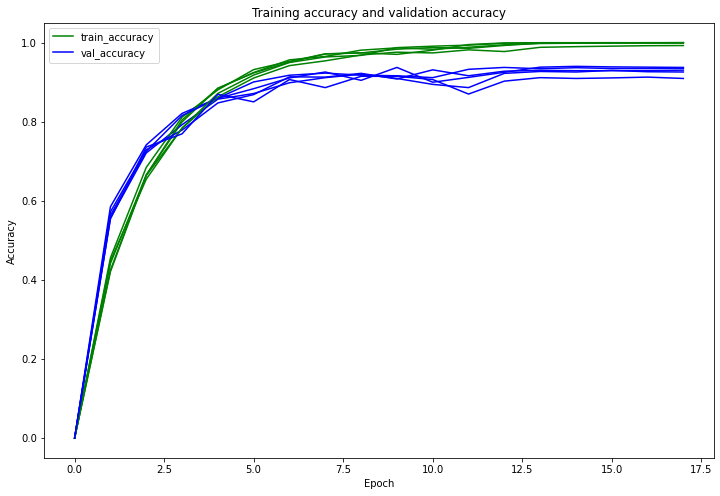

In [115]:

plot_trainAcc_vs_valAcc_for_experiments(res31,res32,17,"","accuracy")

## Representamos gráficamente los resultados obtenidos al experimentar con el tamaño del lote

In [107]:
def compute_values(resx1,resx2,i,val):
    res=[]
    if val != "val_loss":
        res.append(0.0)
    for e in resx1[i].history[val]:
        res.append(e)
    for e in resx2[i].history[val]:
        res.append(e)
    return res




def plot_acc_all_experiments(res11,res12,res21,res22,res31,res32,epochs):
    plt.figure(figsize=(16,10))
    
    acc = "val_accuracy"
    
    for i in range(10):
        
        precisiones = compute_values(res11,res12,i,acc)
            
        precisiones1 = compute_values(res21,res22,i,acc)
        
        precisiones2 = compute_values(res31,res32,i,acc)
        
        
        loss = compute_values(res11,res12,i,"val_loss")
        
        loss1 = compute_values(res21,res22,i,"val_loss")
        
        loss2 = compute_values(res31,res32,i,"val_loss")
        

        if i == 0:
            plt.plot(np.arange(0, epochs+1), precisiones[0:epochs+1], label="Dropout",color='green')
            #plt.plot(np.arange(0, epochs+1), precisiones1[0:epochs+1], label="BachNormalization y Dropout",color='blue')
            plt.plot(np.arange(0, epochs+1), precisiones2[0:epochs+1], label="BachNormalization sin Dropout",color='red')
            #plt.plot(np.arange(0, epochs+1), precisiones3[0:epochs+1], label="Amsgrad",color='aqua')
            #plt.plot(np.arange(0, epochs+1), precisiones4[0:epochs+1], label="Adamax",color='red')
            #plt.plot(np.arange(0, epochs+1), precisiones5[0:epochs+1], label="Nadam",color='deeppink')
            #plt.plot(np.arange(0, epochs+1), precisiones6[0:epochs+1], label="Adadelta",color='yellowgreen')
            
            plt.plot(np.arange(0, epochs+1), loss[0:epochs+1],color='green')
            #plt.plot(np.arange(0, epochs+1), loss1[0:epochs+1],color='blue')
            plt.plot(np.arange(0, epochs+1), loss2[0:epochs+1],color='red')
            #plt.plot(np.arange(0, epochs+1), loss3[0:epochs+1],color='aqua')
            #plt.plot(np.arange(0, epochs+1), loss4[0:epochs+1], label="Adamax",color='red')
            #plt.plot(np.arange(0, epochs+1), loss5[0:epochs+1], label="Nadam",color='deeppink')
            #plt.plot(np.arange(0, epochs+1), loss6[0:epochs+1], label="Adadelta",color='yellowgreen')
            
        else:
            
            plt.plot(np.arange(0, epochs+1), precisiones[0:epochs+1],color='green')
            #plt.plot(np.arange(0, epochs+1), precisiones1[0:epochs+1],color='blue')
            plt.plot(np.arange(0, epochs+1), precisiones2[0:epochs+1],color='red')
            #plt.plot(np.arange(0, epochs+1), precisiones3[0:epochs+1],color='aqua')
            #plt.plot(np.arange(0, epochs+1), precisiones4[0:epochs+1], label="Adamax",color='red')
            #plt.plot(np.arange(0, epochs+1), precisiones5[0:epochs+1], label="Nadam",color='deeppink')
            #plt.plot(np.arange(0, epochs+1), precisiones6[0:epochs+1], label="Adadelta",color='yellowgreen')
            
            plt.plot(np.arange(0, epochs+1), loss[0:epochs+1],color='green')
            #plt.plot(np.arange(0, epochs+1), loss1[0:epochs+1],color='blue')
            plt.plot(np.arange(0, epochs+1), loss2[0:epochs+1],color='red')
            #plt.plot(np.arange(0, epochs+1), loss3[0:epochs+1],color='aqua')
            #plt.plot(np.arange(0, epochs+1), loss4[0:epochs+1],color='red')
            #plt.plot(np.arange(0, epochs+1), loss5[0:epochs+1],color='deeppink')
            #plt.plot(np.arange(0, epochs+1), loss6[0:epochs+1],color='yellowgreen')
            
        del precisiones
        del precisiones1
        del precisiones2


        
    plt.title("Training Accuracy and Test Results")
    plt.xlabel("Epoch")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.savefig("Exp_1_2_kinds.jpg")
    plt.show()
#RMSProp,SGD,Adam,Amsgrad,Adamax,Nadam,Adadelta

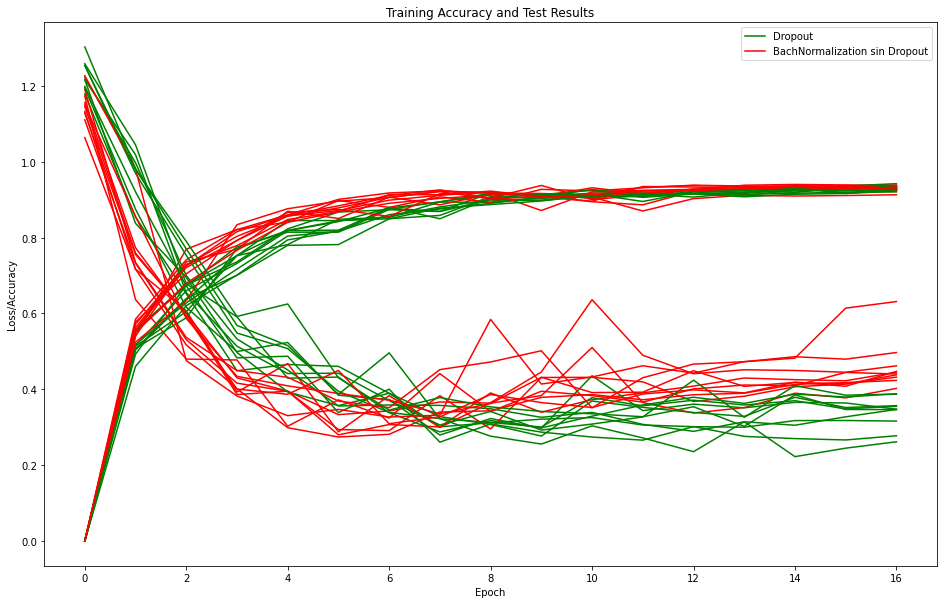

In [108]:
plot_acc_all_experiments(res11,res12,res21,res22,res31,res32,16)

## Creamos marcos de datos para analizar los resultados de evaluar los modelos 

In [109]:
precision1 = []
precision2 = []
precision3 = []
precision4 = []
precision5 = []


for e in evaluations1:
    element = e[1]
    precision1.append(element)
    
for e in evaluations2:
    element = e[1]
    precision2.append(element)
    
for e in evaluations3:
    element = e[1]
    precision3.append(element)


    
#RMSProp,SGD,Adam,Amsgrad,Adamax,Nadam,Adadelta    
    
d = {'Dropout': precision1,'BachNormalization y Dropout': precision2,'BachNormalization sin Dropout':precision3}
df = pd.DataFrame(data=d)

print(df)
print(df.mean())

    Dropout  BachNormalization y Dropout  BachNormalization sin Dropout
0  0.925926                     0.910178                       0.932925
1  0.921260                     0.925343                       0.938174
2  0.927384                     0.923301                       0.927676
3  0.929425                     0.916010                       0.932925
4  0.931175                     0.916594                       0.924176
5  0.932050                     0.924468                       0.932925
6  0.927384                     0.920968                       0.933800
7  0.929717                     0.885389                       0.933508
8  0.929717                     0.930009                       0.931759
9  0.936716                     0.919510                       0.939049
Dropout                          0.929076
BachNormalization y Dropout      0.917177
BachNormalization sin Dropout    0.932692
dtype: float64
